<h1>Defining the error in a neural network</h1>

In this lesson we will recap on creating neural network from scratch, but this time we'll do it in a way that will allow the model to learn. Before the model can improve, we must first measure how well the model is doing in it's inception and in what direction to make changes in order to improve. 

In [24]:
import numpy as np
import nn_framework.activation as activation
import nn_framework.framework as framework
import nn_framework.error_fun as error_fun
import nn_framework.layer as layer
from autoencoder_viz import Printer

In [2]:
# Import torch and a few submodules for convinience
import torch
import torch.nn as nn
import torch.nn.functional as F

# Import numpy for converting torch tensors to arrays that can be displayed
import numpy as np

# Import pyplot to plot things
from matplotlib import pyplot as plt

# For embedding videos
from IPython.display import HTML

# Create the Training Dataset

As with any supervised learning algorithm we'll need some labelled data to feed out model.<br>
We'll start by defining a dictionary of every posible 2 x 2 pixel image

In [3]:
twobytwo_dataset = [
        np.array([
            [0, 0],
            [1, 1]
        ]),
        np.array([
            [1, 0],
            [1, 0]
        ]),
        np.array([
            [1, 1],
            [0, 0]
        ]),
        np.array([
            [0, 1],
            [0, 1]
        ]),
        np.array([
            [1, 0],
            [0, 1]
        ]),
        np.array([
            [0, 1],
            [1, 0]
        ]),
        np.array([
            [0, 1],
            [1, 1]
        ]),
        np.array([
            [1, 1],
            [1, 0]
        ]),
        np.array([
            [1, 0],
            [1, 1]
        ]),
        np.array([
            [1, 1],
            [0, 1]
        ]),
        np.array([
            [1, 0],
            [0, 0]
        ]),
        np.array([
            [0, 0],
            [0, 1]
        ]),
        np.array([
            [0, 1],
            [0, 0]
        ]),
        np.array([
            [0, 0],
            [1, 0]
        ]),
    ]

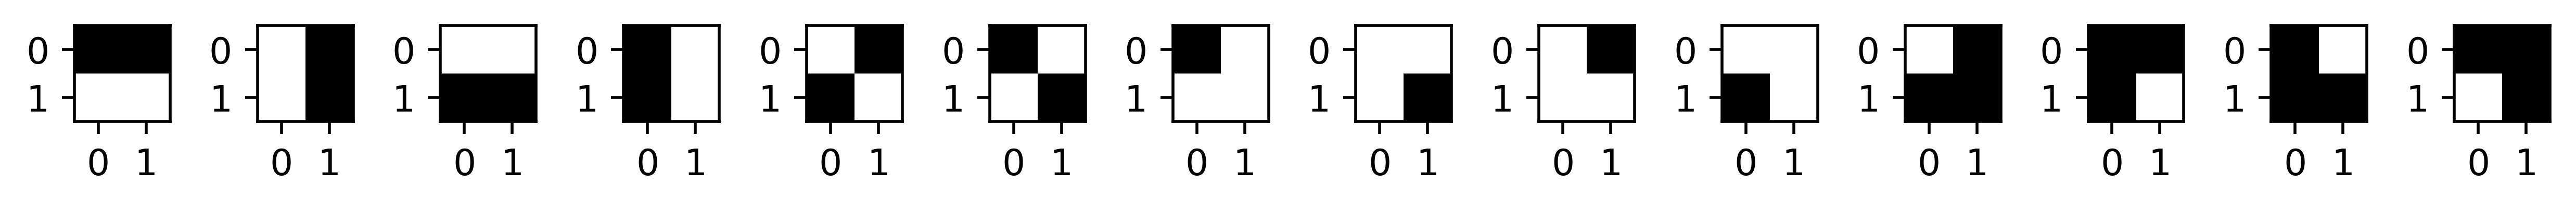

In [4]:
f, axarr = plt.subplots(1,len(twobytwo_dataset))
for i in range(0, len(twobytwo_dataset)):
    axarr[i].imshow(twobytwo_dataset[i], cmap='gray')
    #axarr[i].axis('off')

f.set_size_inches(10, 12, forward=True)
f.set_dpi(500)

plt.tight_layout()
plt.show()

# 1. Define the Neural Network

We'll borrow the network that we build in the previous lesson but instead of of hardcoding the weights we will leave them to their random initialization.
We are also going to define our model as a class instead of a function to that we can remember the weights, 

In [5]:
def old_forward(x):
    
    # Flatten
    x = torch.flatten(x)
    
    # Define fc1
    fc1 = nn.Linear(4, 4, bias = False)

    # Apply fc1
    fc1_out = x = fc1(x)
    # Apply activation function to output of fc1
    x = torch.tanh(x)
    
    # Define fc2
    fc2 = nn.Linear(4, 4, bias = False)

    # Apply fc2
    x = fc2(x)
    # Apply activation function to output of fc2
    x = torch.tanh(x)
    xfc2 = x
    
    # Output layer
    fc3 = nn.Linear(4, 8, bias = False)


    x = fc3(x)
    x = F.relu(x)
    
    return x, fc1_out

In [6]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(4, 4, bias = False)
        self.fc2 = nn.Linear(4, 4, bias = False)
        self.fc3 = nn.Linear(4, 8, bias = False)
        self.fc4 = nn.Linear(8, 4, bias = False)


    def forward(self, x):
        # Flatten
        x = torch.flatten(x)
        
        x = self.fc1(x) # First fully connected layer
        x = torch.tanh(x) # Activation
        
        x = self.fc2(x)
        x = torch.tanh(x)
        
        x = self.fc3(x)
        x = F.relu(x)
        
        x = self.fc4(x)
        #x = F.relu(x)
        return x
    
net = Net()

In [7]:
def label_map(x):
    
    cls = list(x).index(max(x))
    
    if cls == 0 :
        return "solid"
    if cls == 1:
        return "vertical"
    if cls == 2 :
        return "diagonal"
    if cls == 3:
        return "horizontal"

Let's run an image through our model as a sanity check, to make sure our model gives us some output, even if it's wrong.

[[0 0]
 [1 1]]
tensor([-0.0063, -0.0117, -0.0192, -0.0037], grad_fn=<SqueezeBackward3>)
vertical


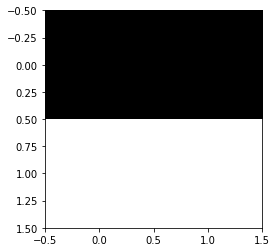

In [9]:
image = twobytwo_dataset[0]
print(image)
x = net.forward(torch.Tensor(image))
y = label_map(x)
print(x)
print(y)

plt.imshow(image, cmap='gray')
plt.show()

In [10]:

test = nn.Linear(4, 4, bias = False).eval()

In [11]:
x = torch.flatten(torch.Tensor(image))
test(torch.Tensor(x))

tensor([-0.4841, -0.7019,  0.5128,  0.1258], grad_fn=<SqueezeBackward3>)

# 2. Calculate The Error

Ok, we ran an input image through the model! But the output is wrong... If you keep running the previous cell, you should see that it's only right 25% of the time. 
However this is exactly what we need to help out neural network learn. Now that we know that the model gives us a wrong answer, we can quantify exactly how wrong that answer is. This is done by using a loss function. 

The most common loss function used for classification tasks is the <b> cross entropy loss</b> defined as $$Cross Entropy Loss(\hat{Y}, Y)   =   - \sum_{i} {Y_i} \times ln( \hat{Y}_i)$$ where $\hat{Y}$ is the array the predictions generated by the model and $Y$ are the ground truth labels.


In [12]:
# Numpy examples
def cross_entropy(y, y_hat):
    return -(sum(y * np.log(y_hat)))

Another thing that is helpful is visualizing the graph of a natural log

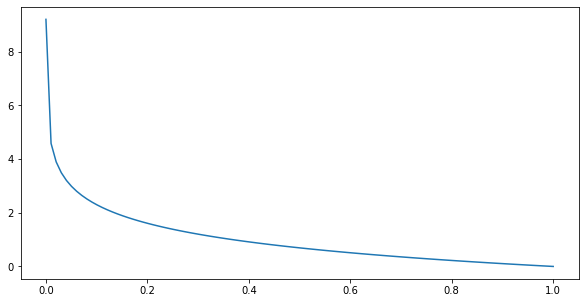

In [13]:
# Creating vectors X and Y
x = np.linspace(0.0001, 1, 100)
y = - np.log(x)
  
fig = plt.figure(figsize = (10, 5))
# Create the plot
plt.plot(x, y)
  
# Show the plot
plt.show()

The graph above shows us the line for $- ln({x})$. For any given prediction to be correct we want the $\hat{Y}$ to be close to 1. Which will give us an error (loss) closer to zero. All the other classes (in a one-hot ecoded array) are effectively ignored since they are multiplied by zero.

Let's see some examples:

In [14]:
Y = [1, 0, 0] # One-hot encoded vector for class zero

Y_hat_a = [0.7, 0.2, 0.1] # Good prediction
Y_hat_b = [0.1, 0.3, 0.6] # Bad Prediction

print(cross_entropy(Y, Y_hat_a))
print(cross_entropy(Y, Y_hat_b))

0.35667494393873245
2.3025850929940455


In [15]:
HTML('<iframe width="560" height="315" src="https://www.youtube.com/embed/ArxdklCAKs0" title="YouTube video player" frameborder="0" allow="accelerometer; autoplay; clipboard-write; encrypted-media; gyroscope; picture-in-picture" allowfullscreen></iframe>')

/usr/lib/python3/dist-packages/IPython/core/display.py:701: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


In [16]:
HTML('<iframe width="560" height="315" src="https://www.youtube.com/embed/7q7E91pHoW4" title="YouTube video player" frameborder="0" allow="accelerometer; autoplay; clipboard-write; encrypted-media; gyroscope; picture-in-picture" allowfullscreen></iframe>')

Another popular function that is often used in conjunction with the cross entropy loss is the <b> softmax </b> function.
The softmax function gives use the probability distribution of each class for a given output. The sum of all the probabilities will be equal to 1.

In [17]:
def softmax(x):
    return np.exp(x) / np.sum(np.exp(x), axis=0)

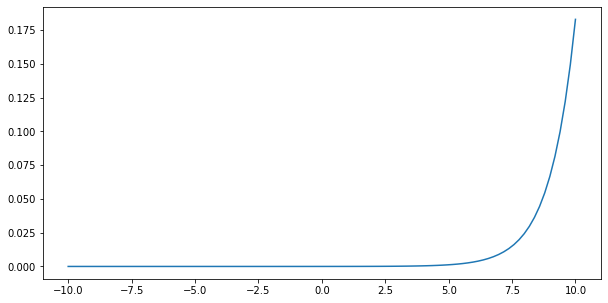

1.0

In [18]:
# Creating vectors X and Y
x = np.linspace(-10, 10, 100)
y = softmax(x)
  
fig = plt.figure(figsize = (10, 5))
# Create the plot
plt.plot(x, y)
  
# Show the plot
plt.show()

sum(y)

In [19]:
HTML('<iframe width="560" height="315" src="https://www.youtube.com/embed/LLux1SW--oM" title="YouTube video player" frameborder="0" allow="accelerometer; autoplay; clipboard-write; encrypted-media; gyroscope; picture-in-picture" allowfullscreen></iframe>')

/usr/lib/python3/dist-packages/IPython/core/display.py:701: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


In [20]:
# Softmax + Cross Entropy

Y = [1, 0, 0] # One-hot encoded vector for class zero

Y_hat_a = [0.7, 0.2, 0.1] # Good prediction
Y_hat_b = [0.1, 0.3, 0.6] # Bad Prediction

print(cross_entropy(Y, softmax(Y_hat_a)))
print(cross_entropy(Y, softmax(Y_hat_b)))

0.7679495489036249
1.353286555329249


In PyTorch the cross entropy loss is implemented in combination with the sofmax function.

In [21]:
loss = nn.CrossEntropyLoss()

Y = torch.tensor([0]) # Class zero is passed directly (not one-hot encoded)

Y_hat_a = torch.tensor([[0.7, 0.2, 0.1]]) # Good prediction
Y_hat_b = torch.tensor([[0.1, 0.3, 0.6]]) # Bad Prediction

print(Y)
print(Y_hat_a)

print(loss(Y_hat_a, Y))
print(loss(Y_hat_b, Y))

tensor([0])
tensor([[0.7000, 0.2000, 0.1000]])
tensor(0.7679)
tensor(1.3533)


Let's now calculate the error of our network on a single image

In [23]:
image = twobytwo_dataset[0] # Vertical Image
Y = torch.tensor([1]) # solid, vertical, diagonal, horizontal

# Forward pass through the model (a.k.a inference)
Y_hat = net.forward(torch.Tensor(image))

Y_hat = (torch.tensor([Y_hat.detach().numpy()]))
print(Y_hat)
Y_hat_a = torch.tensor([[2.5, 0.2, 0.1, 0.3]]) # Good prediction

# Softmax and Cross Entropy Loss
#loss.zero_grad()
#print(loss(Y_hat_a, Y))
print(loss(Y_hat, Y))

#plt.imshow(image, cmap='gray')
#plt.show()

tensor([[-0.0063, -0.0117, -0.0192, -0.0037]])
tensor(1.3878)


Now we know what each neuron of the final layer predicted we know in which direction to change them in order to have a better prediction. For example in the output of the model was tensor([[0.0347,  0.0620, 0.0388, 0.0108]]) and the correct label was index 1 then this prediction was technically correct, since the number at index 1 is the highest. The fact that it's correct in this example is just random chance (luck). We want to make the model more confident in it's correct predictions and discourage the wrong neurons from fiering. We wan't to increase the correct neuron until the error is zero (which for Cross entropy means having the weight of the neuron be $e$), while the neurons corresponding to corresponding to incorrect labels should be zero.

Once we know how the last layer needs to change, we can apply the same logic the the previous layer as well, and then to the one before that... and the one before that...

# 2.5 Other loss functions

There are a handfull of other loss functions that are commonly used in deep learning. Custom loss functions are also very popular for complex models with vairous components which optimize for different things. For example in object detection you have to optimize for classification as well as localization).

Here's a good resource that goes over some common <a href='https://neptune.ai/blog/pytorch-loss-functions'> loss functions</a>

# 3. Backpropagation / Gradient Descent

Now that we have the error we need to find the down hill direction of the loss function! To do that we'll need the calculate the derivative (gradient) of our loss function (And then every other weigth in the network using the chain rule. 

This is also a great place to take a break and watch the following playlist by <a href="https://www.youtube.com/playlist?list=PLZHQObOWTQDNU6R1_67000Dx_ZCJB-3pi">3Blue1Brown</a>

Please, please, please watch all the video in that playlist. You can skip the first video if you are pressed for time, but I do really recommend them.

# Train the Model

In [ ]:
for epoch in range(10):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        #inputs, labels = data
        inputs, labels = data
            
        
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

# Test the Model